In [1]:
import os
import os.path as op
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,5))

# Define experimental info and ROIs

In [3]:
smoothing = 'smoothed'
regspace = 'epi'

exp = 'mag-SVtotaldiff'

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_ifs',
       '_ains',
       '.vmpfc_']

# Main functions for extracting and analysing ROI data

In [4]:
def extract_copes(exp,regspace,smoothing,contrast):
    df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

    for sub in subs:
        cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
            '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
        cope = nib.load(cope).get_data()

        masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
        masks = [m for m in masks if any(substring in m for substring in rois)]

        for m in masks:
            if len(m.split('/')[-1].split('.'))==4:
                hemi = m.split('/')[-1].split('.')[0]
                label = m.split('/')[-1].split('.')[1]
            else:
                hemi = 'na'
                label = m.split('/')[-1].split('.')[0]

            m = nib.load(m).get_data().astype(bool)
            num_voxels = m.sum()
            func_masked = cope[m]
            row = pd.DataFrame([dict(sub = sub, 
                                     contrast =contrast, 
                                     mask_vox = num_voxels, 
                                     hemi = hemi,
                                     label = label, 
                                     value = np.mean(func_masked)), ])
            df = df.append(row, ignore_index = True)
    return df

In [5]:
def plot_fig(res,contrast):
    plt.figure(figsize=(10, 6))

    #relabel
    res = res.copy()
    res['ROI'] = [label_map[x] for x in res['label'].values]
    
    #sort dataframe
    res['ROI'] = pd.Categorical(res['ROI'],roi_plotting_order)
    res = res.sort('ROI')

    #plot
    sns.barplot(x='ROI',y='val',data = res,
                **{'yerr':res['err'],
                   'error_kw':dict(ecolor='grey', lw=2.5)}
                )
    sns.despine()
    plt.ylabel('Beta (AU)')
    plt.title(title_map[contrast])
    plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.svg')

In [6]:
def run_stats(df):
    results_df =pd.DataFrame(columns=('contrast','label','nvox',
                                      'std_vox','p_unc','val','err'))
    for roi in set(df['label']):

        new = df[df['label'] == roi]

        #run mixed effects model
        model_str = 'value ~ 1'
        mixedfx = smf.mixedlm(model_str, new, groups = new['sub'])    
        mixedfx = mixedfx.fit()
        
        #extract p value and errors
        p = mixedfx.pvalues['Intercept']
        val = mixedfx.params[0]
#         err = mixedfx.bse_fe[0] #standard error
        conf_int = mixedfx.conf_int()
        err = (conf_int.loc['Intercept',1] - conf_int.loc['Intercept',0]) / 2.0 #plots 95% conf
        
        #update dataframe
        row = pd.DataFrame([dict(contrast = contrast, 
                                 label = roi,
                                 nvox = np.mean(new['mask_vox']),
                                 val = val,
                                 err = err,
                                p_unc = p), ])
        results_df = results_df.append(row, ignore_index = True)
        
    #correct for multiple comparisons
    sig,pcorr,a1,a2 = multipletests(results_df['p_unc'],.05,method = 'fdr_tsbh')
    results_df['p_corr'] = pcorr
    results_df['sig'] = sig
    return results_df


In [7]:
def run_contrast(exp,regspace,smoothing,contrast):
    df = extract_copes(exp,regspace,smoothing,contrast)
    df['ROI'] = [label_map[x] for x in df['label'].values]
    
    df.to_csv('/home/iballard/Dropbox/Magnitude_fMRI/roi_analysis/' + exp  + '_' + contrast + '.csv',
              index = False)
    
    results = run_stats(df)
    results['ROI'] = [label_map[x] for x in results['label'].values]

    plot_fig(results,contrast)

    return results

# Set up figure aesthetics

In [8]:
label_map = {'yeo17_amfg':'aMFG','yeo17_pmfg':'pMFG','yeo17_ains':'aINS','yeo17_fpc':'FPC',
            'yeo17_ifs':'IFS','yeo17_ifg':'IFG','yeo17_psfs':'FEF','vmpfc_bartre':'vmPFC'}
roi_plotting_order = ['IFS','FPC','pMFG','FEF','aINS','IFG','aMFG','vmPFC']

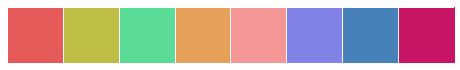

In [9]:
#get colors from ROI figure and match them
ctab = '/home/iballard/mag/data/fsaverage/label/pfc.ctab'
color = np.loadtxt(ctab,object)
custom_palette = []
for row in color:
    rgb = (int(row[2]),int(row[3]),int(row[4]))
    hex_rgb = '#%02x%02x%02x' % rgb
    roi_id = label_map[row[1]]
    custom_palette.append((hex_rgb, roi_id))

custom_palette.sort(key=lambda x: roi_plotting_order.index(x[1]))
custom_palette = [x[0] for x in custom_palette]

sns.set_palette(custom_palette)
sns.palplot(sns.color_palette())

In [10]:
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [11]:
#for figure plotting
title_map = {'decision': 'Decision Period', 
             'SV_total': 'Subjective Value',
             'neg_SV_diff': 'Difficulty',
             'low_minus_high_SV_diff': 'Difficulty (High minus Low Magnitude)',
             'high_minus_low_SV': 'Subjective Value (High minus Low Magnitude)',
            'high_minus_low': 'High minus Low Magnitude'}
contrasts = title_map.keys()

# Run analysis

In [17]:
all_results = []

for contrast in contrasts:
    results = run_contrast(exp,regspace,smoothing,contrast)
    all_results.append(results.copy())
    
all_results = pd.concat(all_results)
all_results = all_results.set_index(['contrast'])

In [14]:
all_results.to_csv('/home/iballard/Dropbox/mag_figs/roi_results.csv',index = False)
all_results[['ROI','p_unc','p_corr','sig']]

,ROI,p_unc,p_corr,sig
contrast,,,,
SV_total,IFG,5.069563e-01,6.159608e-01,False
SV_total,FPC,8.434879e-01,7.380519e-01,False
SV_total,aMFG,4.175301e-01,6.159608e-01,False
SV_total,aINS,8.087778e-01,7.380519e-01,False
SV_total,IFS,3.896351e-02,1.363723e-01,False
SV_total,pMFG,2.687953e-01,6.159608e-01,False
SV_total,vmPFC,1.755664e-03,1.228965e-02,True
SV_total,FEF,5.279664e-01,6.159608e-01,False
decision,IFG,6.289789e-07,4.717342e-07,True


# Run brain-behavior correlation

In [960]:
params = pd.read_csv('/home/iballard/Dropbox/Magnitude_fMRI/model_fits.csv')
params['mag_effect'] = np.array(map(np.log,params['k_low'])) - np.array(map(np.log,params['k_high']))
bad_subs = ['asu03','asu09','subject22']
for s in bad_subs:
    params = params[params['sub'] != s]
params = params.reset_index()

In [961]:
for n,s in enumerate(params['sub']):
    if s == 'asu04':
        params['sub'][n] = 'asu4'
    if s == 'asu08':
        params['sub'][n] = 'asu8'

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


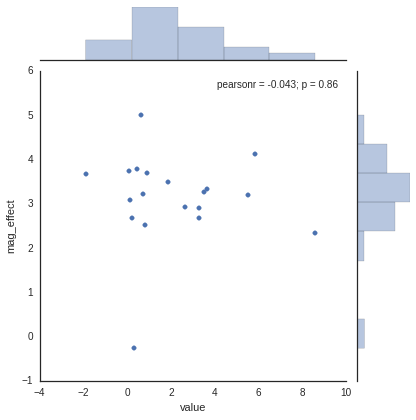

In [972]:
ifs2 = ifs.groupby('sub').mean().reset_index()
ifs2 = pd.merge(ifs2,
         params,
        how = 'left',
        on = 'sub')
sns.jointplot(x = 'value',y= 'mag_effect', data = ifs2)

In [946]:
# ifs2.columns = ifs2.columns.get_level_values(0)
# ifs2['mag_effect'] = params['mag_effect']